Dry run of final experiment!

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import importlib
import os
import sys

from algorithms.langevin import *
from base.experiment import *
from logistic.env_logistic import *
from logistic.agent_logistic import *
from utils import *

import numpy as np
import scipy
import numpy.linalg as npla
import scipy.linalg as spla
import pandas as pd
import pickle
import plotnine as gg

import warnings
warnings.filterwarnings('ignore')

In [2]:
#pgts not quite right (dealing with constant term), fix this later

def plot_results(results):
    df = pd.DataFrame(results[0])
    #https://stackoverflow.com/questions/39092067/pandas-dataframe-convert-column-type-to-string-or-categorical
    df['agent_id'] = df.agent_id.astype('category')
    print(gg.ggplot(df)
     + gg.aes('t', 'cum_regret', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    print(gg.ggplot(df)
     + gg.aes('t', 'time', color='agent_id', group='agent_id')
     + gg.geom_point()
     + gg.geom_line())
    
def plot_results_list(results_list):
    for results in results_list:
        plot_results(results)

def simple_compare(agents, num_articles, dim, sparsity, n_steps, seed=0, verbosity=0, graph=False):
    #env = FixedLogisticBandit(num_articles, dim, DistributionWithConstant(NormalDist(0,1,dim=dim-1),-2.5), DistributionWithConstant(BernoulliDist(5.0/(dim-1),dim-1)), seed=seed)
    env = LogisticBandit(num_articles, dim+1, NormalDist(0,1,dim=dim+1), DistributionWithConstant(BernoulliDist(sparsity/dim,dim)), seed=seed)
    experiment = ExperimentCompare(agents, env, n_steps,
                   seed=seed, verbosity=verbosity)
    experiment.run_experiment()
    results = []
    results.append(experiment.results)
    cum_regrets = experiment.cum_regret
    if graph:
        plot_results(results)
    return results, cum_regrets

def simple_compares(make_agents, num_articles, dim, var, n_steps, seeds, verbosity=0, graph=False):
    results_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(make_agents))
    for seed in seeds:
        agents = [make_agent() for make_agent in make_agents]
        results, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity, graph=graph)
        results_list += [results]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / len(seeds)
    return results_list, cum_regrets_list, avg_regrets

def hyperparameter_sweep(make_agent_from_hyperparameters, hyperparam_list, dim, sparsity, n_steps, seed=0, verbosity=0, graph=False):
    agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
    results, cum_regrets = simple_compare(agents, num_articles, dim, sparsity, n_steps, seed=seed, verbosity=verbosity, graph=graph)
    
"""def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):
    results_list = []
    df_list = []
    cum_regrets_list = []
    avg_regrets = np.zeros(len(hyperparam_list))
    for seed in range(seeds):
        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]
        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)
        results_list += [results]
        df_list += [df]
        cum_regrets_list += [cum_regrets]
        avg_regrets += cum_regrets
    avg_regrets = avg_regrets / seeds
    return results_list, df_list, cum_regrets_list, avg_regrets"""


'def hyperparameter_sweeps(make_agent_from_hyperparameters, hyperparam_list, dim, var, n_steps, seeds, verbosity=0):\n    results_list = []\n    df_list = []\n    cum_regrets_list = []\n    avg_regrets = np.zeros(len(hyperparam_list))\n    for seed in range(seeds):\n        agents = [make_agent_from_hyperparameters(hyperparam) for hyperparam in hyperparam_list]\n        results, df, cum_regrets = simple_compare(agents, num_articles, dim, var, n_steps, seed=seed, verbosity=verbosity)\n        results_list += [results]\n        df_list += [df]\n        cum_regrets_list += [cum_regrets]\n        avg_regrets += cum_regrets\n    avg_regrets = avg_regrets / seeds\n    return results_list, df_list, cum_regrets_list, avg_regrets'

In [3]:
seed=1

num_articles = 100
dim = 100
dim1= dim+1
sparsity = 5.0
theta_mean = 0
theta_std = 1

time_limit= 0.01

verbosity=0

In [4]:
# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.

epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim1, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

## Online version

make_online_laplace_agent = lambda: OnlineDiagLaplaceTS(num_articles,dim1, [0]*dim1,
                                                        cov=None,init_pt=None,time=False,verbosity=0)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=True, context_has_constant=True, 
                                      n_steps=9999, time = time_limit, verbosity=verbosity)
#self, num_articles, dim, intercept=False, context_has_constant=False, time=False, n_steps=100, verbosity=0

# Langevin-based

make_mala_agent = lambda: MalaTS(num_articles, dim1, [0]*(dim1), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(sparsity/dim)), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)

## Untimed MALA agent is used as baseline.
## I don't know whether I should use 1+t or 1+\sqrt{sparsity/dim}*t

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim1, [0]*dim1, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(sparsity/dim)), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

## With stochastic gradients


make_sgld_agent = lambda: SGLDTS(num_articles, dim1, [0]*(dim1), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(sparsity/dim)),
                                        batch_size = 64,
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(sparsity/dim)),
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)
make_langevin_agent = lambda: BasicLangevinTS(num_articles, dim1, [0]*(dim1), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(sparsity/dim)), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)

make_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='proper',
                                          init_pt=None, verbosity=verbosity)
make_prec_cum_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='cum',
                                          init_pt=None, verbosity=verbosity)

In [5]:
#https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
agents = [make_laplace_agent(),
          make_online_laplace_agent(),
          make_pgts_agent(),
          make_langevin_agent(),
          make_mala_agent(),
          make_sgld_agent(),
          make_sagald_agent(),
          make_prec_sagald_agent(),
          make_prec_cum_sagald_agent()]
                #,make_mala_agent_untimed]
results, cum_regrets = simple_compare(agents, num_articles, dim, sparsity, 1000, seed=seed, verbosity=1)

theta [ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  1.74481176 -0.7612069   0.3190391  -0.24937038  1.46210794 -2.06014071
 -0.3224172  -0.38405435  1.13376944 -1.09989127 -0.17242821 -0.87785842
  0.04221375  0.58281521 -1.10061918  1.14472371  0.90159072  0.50249434
  0.90085595 -0.68372786 -0.12289023 -0.93576943 -0.26788808  0.53035547
 -0.69166075 -0.39675353 -0.6871727  -0.84520564 -0.67124613 -0.0126646
 -1.11731035  0.2344157   1.65980218  0.74204416 -0.19183555 -0.88762896
 -0.74715829  1.6924546   0.05080775 -0.63699565  0.19091548  2.10025514
  0.12015895  0.61720311  0.30017032 -0.35224985 -1.1425182  -0.34934272
 -0.20889423  0.58662319  0.83898341  0.93110208  0.28558733  0.88514116
 -0.75439794  1.25286816  0.51292982 -0.29809284  0.48851815 -0.07557171
  1.13162939  1.51981682  2.18557541 -1.39649634 -1.44411381 -0.50446586
  0.16003707  0.87616892  0.31563495 -2.02220122 -0.30620401  0.82797464
  0.23009474  0.76201118 -0.22232814 -0.2007580

Experiment: Step 202
(101,) (101,)
Experiment: Step 203
(101,) (101,)
Experiment: Step 204
(101,) (101,)
Experiment: Step 205
(101,) (101,)
Experiment: Step 206
(101,) (101,)
Experiment: Step 207
(101,) (101,)
Experiment: Step 208
(101,) (101,)
Experiment: Step 209
(101,) (101,)
Experiment: Step 210
(101,) (101,)
Experiment: Step 211
(101,) (101,)
Experiment: Step 212
(101,) (101,)
Experiment: Step 213
(101,) (101,)
Experiment: Step 214
(101,) (101,)
Experiment: Step 215
(101,) (101,)
Experiment: Step 216
(101,) (101,)
Experiment: Step 217
(101,) (101,)
Experiment: Step 218
(101,) (101,)
Experiment: Step 219
(101,) (101,)
Experiment: Step 220
(101,) (101,)
Experiment: Step 221
(101,) (101,)
Experiment: Step 222
(101,) (101,)
Experiment: Step 223
(101,) (101,)
Experiment: Step 224
(101,) (101,)
Experiment: Step 225
(101,) (101,)
Experiment: Step 226
(101,) (101,)
Experiment: Step 227
(101,) (101,)
Experiment: Step 228
(101,) (101,)
Experiment: Step 229
(101,) (101,)
Experiment: Step 230

Experiment: Step 437
(101,) (101,)
Experiment: Step 438
(101,) (101,)
Experiment: Step 439
(101,) (101,)
Experiment: Step 440
(101,) (101,)
Experiment: Step 441
(101,) (101,)
Experiment: Step 442
(101,) (101,)
Experiment: Step 443
(101,) (101,)
Experiment: Step 444
(101,) (101,)
Experiment: Step 445
(101,) (101,)
Experiment: Step 446
(101,) (101,)
Experiment: Step 447
(101,) (101,)
Experiment: Step 448
(101,) (101,)
Experiment: Step 449
(101,) (101,)
Experiment: Step 450
(101,) (101,)
Experiment: Step 451
(101,) (101,)
Experiment: Step 452
(101,) (101,)
Experiment: Step 453
(101,) (101,)
Experiment: Step 454
(101,) (101,)
Experiment: Step 455
(101,) (101,)
Experiment: Step 456
(101,) (101,)
Experiment: Step 457
(101,) (101,)
Experiment: Step 458
(101,) (101,)
Experiment: Step 459
(101,) (101,)
Experiment: Step 460
(101,) (101,)
Experiment: Step 461
(101,) (101,)
Experiment: Step 462
(101,) (101,)
Experiment: Step 463
(101,) (101,)
Experiment: Step 464
(101,) (101,)
Experiment: Step 465

(101,) (101,)
Experiment: Step 672
(101,) (101,)
Experiment: Step 673
(101,) (101,)
Experiment: Step 674
(101,) (101,)
Experiment: Step 675
(101,) (101,)
Experiment: Step 676
(101,) (101,)
Experiment: Step 677
(101,) (101,)
Experiment: Step 678
(101,) (101,)
Experiment: Step 679
(101,) (101,)
Experiment: Step 680
(101,) (101,)
Experiment: Step 681
(101,) (101,)
Experiment: Step 682
(101,) (101,)
Experiment: Step 683
(101,) (101,)
Experiment: Step 684
(101,) (101,)
Experiment: Step 685
(101,) (101,)
Experiment: Step 686
(101,) (101,)
Experiment: Step 687
(101,) (101,)
Experiment: Step 688
(101,) (101,)
Experiment: Step 689
(101,) (101,)
Experiment: Step 690
(101,) (101,)
Experiment: Step 691
(101,) (101,)
Experiment: Step 692
(101,) (101,)
Experiment: Step 693
(101,) (101,)
Experiment: Step 694
(101,) (101,)
Experiment: Step 695
(101,) (101,)
Experiment: Step 696
(101,) (101,)
Experiment: Step 697
(101,) (101,)
Experiment: Step 698
(101,) (101,)
Experiment: Step 699
(101,) (101,)
Experi

Experiment: Step 906
(101,) (101,)
Experiment: Step 907
(101,) (101,)
Experiment: Step 908
(101,) (101,)
Experiment: Step 909
(101,) (101,)
Experiment: Step 910
(101,) (101,)
Experiment: Step 911
(101,) (101,)
Experiment: Step 912
(101,) (101,)
Experiment: Step 913
(101,) (101,)
Experiment: Step 914
(101,) (101,)
Experiment: Step 915
(101,) (101,)
Experiment: Step 916
(101,) (101,)
Experiment: Step 917
(101,) (101,)
Experiment: Step 918
(101,) (101,)
Experiment: Step 919
(101,) (101,)
Experiment: Step 920
(101,) (101,)
Experiment: Step 921
(101,) (101,)
Experiment: Step 922
(101,) (101,)
Experiment: Step 923
(101,) (101,)
Experiment: Step 924
(101,) (101,)
Experiment: Step 925
(101,) (101,)
Experiment: Step 926
(101,) (101,)
Experiment: Step 927
(101,) (101,)
Experiment: Step 928
(101,) (101,)
Experiment: Step 929
(101,) (101,)
Experiment: Step 930
(101,) (101,)
Experiment: Step 931
(101,) (101,)
Experiment: Step 932
(101,) (101,)
Experiment: Step 933
(101,) (101,)
Experiment: Step 934

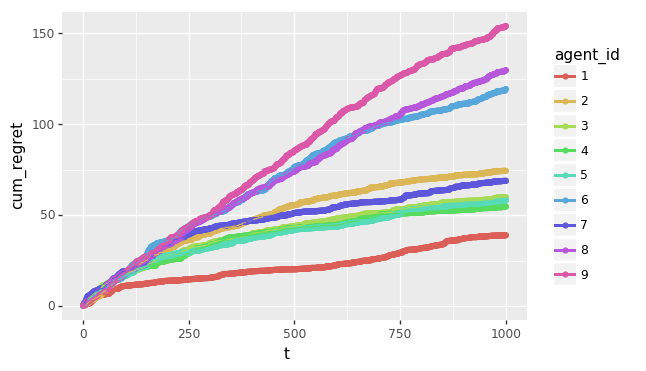

<ggplot: (8764675464401)>


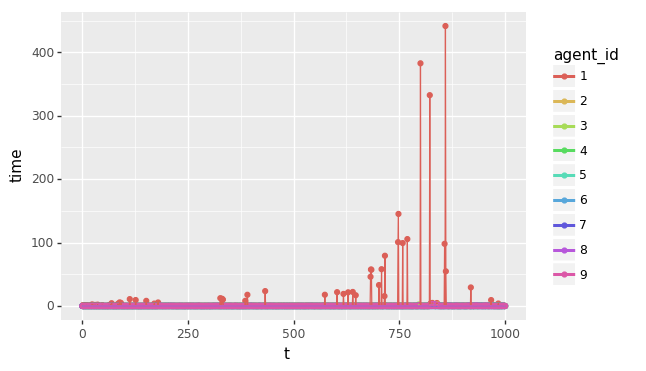

<ggplot: (8764675450457)>


In [8]:
plot_results(results)
"""
make_laplace_agent(),
          make_online_laplace_agent(),
          make_pgts_agent(),
          make_langevin_agent(),
          make_mala_agent(),
          make_sgld_agent(),
          make_sagald_agent(),
          make_prec_sagald_agent(),
          make_prec_cum_sagald_agent()
"""

In [10]:
pickle.dump((results,cum_regrets), open('../outputs/experiments12_data.p','wb'))

d=20

In [11]:
seed=101

num_articles = 100
dim = 20
dim1= dim+1
sparsity = 5.0
theta_mean = 0
theta_std = 1

time_limit= 0.01

verbosity=0

In [21]:
# Use default settings for Laplace agent for now (would be nice to tune this too). Not time-restricted.

epsilon1 = 0.01
epsilon2 = 0.05
alpha=0.2
beta=0.5
tol=0.0001
make_laplace_agent = lambda: LaplaceTSLogisticBandit(num_articles, dim1, theta_mean, theta_std, epsilon1,
                                                      alpha,beta,tol, verbosity=verbosity)

## Online version

make_online_laplace_agent = lambda: OnlineDiagLaplaceTS(num_articles,dim1, [0]*dim1,
                                                        cov=None,init_pt=None,time=False,verbosity=0)

# PG-TS has no parameters to tune

make_pgts_agent = lambda: PGTS_Stream(num_articles, dim, intercept=True, context_has_constant=True, 
                                      n_steps=9999, time = time_limit, verbosity=verbosity)
#self, num_articles, dim, intercept=False, context_has_constant=False, time=False, n_steps=100, verbosity=0

# Langevin-based

make_mala_agent = lambda: MalaTS(num_articles, dim1, [0]*(dim1), cov=None, 
                                 step_size=lambda t: 0.1/(1 + t * np.sqrt(sparsity/dim)), n_steps=9999,
                                 time = time_limit,
                                     init_pt=None, verbosity=verbosity)

## Untimed MALA agent is used as baseline.
## I don't know whether I should use 1+t or 1+\sqrt{sparsity/dim}*t

make_mala_agent_untimed = lambda: MalaTS(num_articles, dim1, [0]*dim1, cov=None, 
                                         step_size=lambda t: 0.1/(1 + t * np.sqrt(sparsity/dim)), n_steps=500,
                                         init_pt=None, verbosity=verbosity)

## With stochastic gradients


make_sgld_agent = lambda: SGLDTS(num_articles, dim1, [0]*(dim1), cov=None, 
                                        step_size=lambda t: 0.01/(1 + t * np.sqrt(sparsity/dim)),
                                        batch_size = 64,
                                        time=time_limit,
                                        n_steps=9999,
                                        init_pt=None, verbosity=verbosity)
make_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05/(1 + t * np.sqrt(sparsity/dim)),
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)
make_langevin_agent = lambda: BasicLangevinTS(num_articles, dim1, [0]*(dim1), cov=None, 
                                              step_size=lambda t: 0.1/(1 + t * np.sqrt(sparsity/dim)), n_steps=9999,
                                              time = time_limit,
                                              init_pt=None, verbosity=verbosity)

make_prec_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='proper',
                                          init_pt=None, verbosity=verbosity)
make_prec_cum_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='cum',
                                          init_pt=None, verbosity=verbosity)
make_prec_full_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=time_limit,
                                          n_steps=9999,
                                          precondition='full',
                                          init_pt=None, verbosity=verbosity)

In [13]:
#https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
agents = [make_laplace_agent(),
          make_online_laplace_agent(),
          make_pgts_agent(),
          make_langevin_agent(),
          make_mala_agent(),
          make_sgld_agent(),
          make_sagald_agent(),
          make_prec_sagald_agent(),
          make_prec_cum_sagald_agent()]
                #,make_mala_agent_untimed]
results, cum_regrets = simple_compare(agents, num_articles, dim, sparsity, 1000, seed=seed, verbosity=1)

theta [ 2.70684984  0.62813271  0.90796945  0.50382575  0.65111795 -0.31931804
 -0.84807698  0.60596535 -2.01816824  0.74012206  0.52881349 -0.58900053
  0.18869531 -0.75887206 -0.93323722  0.95505651  0.19079432  1.97875732
  2.60596728  0.68350889  0.30266545]
Experiment: Step 0
(21,) (21,)
Experiment: Step 1
(21,) (21,)
Experiment: Step 2
(21,) (21,)
Experiment: Step 3
(21,) (21,)
Experiment: Step 4
(21,) (21,)
Experiment: Step 5
(21,) (21,)
Experiment: Step 6
(21,) (21,)
Experiment: Step 7
(21,) (21,)
Experiment: Step 8
(21,) (21,)
Experiment: Step 9
(21,) (21,)
Experiment: Step 10
(21,) (21,)
Experiment: Step 11
(21,) (21,)
Experiment: Step 12
(21,) (21,)
Experiment: Step 13
(21,) (21,)
Experiment: Step 14
(21,) (21,)
Experiment: Step 15
(21,) (21,)
Experiment: Step 16
(21,) (21,)
Experiment: Step 17
(21,) (21,)
Experiment: Step 18
(21,) (21,)
Experiment: Step 19
(21,) (21,)
Experiment: Step 20
(21,) (21,)
Experiment: Step 21
(21,) (21,)
Experiment: Step 22
(21,) (21,)
Experiment:

(21,) (21,)
Experiment: Step 244
(21,) (21,)
Experiment: Step 245
(21,) (21,)
Experiment: Step 246
(21,) (21,)
Experiment: Step 247
(21,) (21,)
Experiment: Step 248
(21,) (21,)
Experiment: Step 249
(21,) (21,)
Experiment: Step 250
(21,) (21,)
Experiment: Step 251
(21,) (21,)
Experiment: Step 252
(21,) (21,)
Experiment: Step 253
(21,) (21,)
Experiment: Step 254
(21,) (21,)
Experiment: Step 255
(21,) (21,)
Experiment: Step 256
(21,) (21,)
Experiment: Step 257
(21,) (21,)
Experiment: Step 258
(21,) (21,)
Experiment: Step 259
(21,) (21,)
Experiment: Step 260
(21,) (21,)
Experiment: Step 261
(21,) (21,)
Experiment: Step 262
(21,) (21,)
Experiment: Step 263
(21,) (21,)
Experiment: Step 264
(21,) (21,)
Experiment: Step 265
(21,) (21,)
Experiment: Step 266
(21,) (21,)
Experiment: Step 267
(21,) (21,)
Experiment: Step 268
(21,) (21,)
Experiment: Step 269
(21,) (21,)
Experiment: Step 270
(21,) (21,)
Experiment: Step 271
(21,) (21,)
Experiment: Step 272
(21,) (21,)
Experiment: Step 273
(21,) (21,

(21,) (21,)
Experiment: Step 493
(21,) (21,)
Experiment: Step 494
(21,) (21,)
Experiment: Step 495
(21,) (21,)
Experiment: Step 496
(21,) (21,)
Experiment: Step 497
(21,) (21,)
Experiment: Step 498
(21,) (21,)
Experiment: Step 499
(21,) (21,)
Experiment: Step 500
(21,) (21,)
Experiment: Step 501
(21,) (21,)
Experiment: Step 502
(21,) (21,)
Experiment: Step 503
(21,) (21,)
Experiment: Step 504
(21,) (21,)
Experiment: Step 505
(21,) (21,)
Experiment: Step 506
(21,) (21,)
Experiment: Step 507
(21,) (21,)
Experiment: Step 508
(21,) (21,)
Experiment: Step 509
(21,) (21,)
Experiment: Step 510
(21,) (21,)
Experiment: Step 511
(21,) (21,)
Experiment: Step 512
(21,) (21,)
Experiment: Step 513
(21,) (21,)
Experiment: Step 514
(21,) (21,)
Experiment: Step 515
(21,) (21,)
Experiment: Step 516
(21,) (21,)
Experiment: Step 517
(21,) (21,)
Experiment: Step 518
(21,) (21,)
Experiment: Step 519
(21,) (21,)
Experiment: Step 520
(21,) (21,)
Experiment: Step 521
(21,) (21,)
Experiment: Step 522
(21,) (21,

(21,) (21,)
Experiment: Step 742
(21,) (21,)
Experiment: Step 743
(21,) (21,)
Experiment: Step 744
(21,) (21,)
Experiment: Step 745
(21,) (21,)
Experiment: Step 746
(21,) (21,)
Experiment: Step 747
(21,) (21,)
Experiment: Step 748
(21,) (21,)
Experiment: Step 749
(21,) (21,)
Experiment: Step 750
(21,) (21,)
Experiment: Step 751
(21,) (21,)
Experiment: Step 752
(21,) (21,)
Experiment: Step 753
(21,) (21,)
Experiment: Step 754
(21,) (21,)
Experiment: Step 755
(21,) (21,)
Experiment: Step 756
(21,) (21,)
Experiment: Step 757
(21,) (21,)
Experiment: Step 758
(21,) (21,)
Experiment: Step 759
(21,) (21,)
Experiment: Step 760
(21,) (21,)
Experiment: Step 761
(21,) (21,)
Experiment: Step 762
(21,) (21,)
Experiment: Step 763
(21,) (21,)
Experiment: Step 764
(21,) (21,)
Experiment: Step 765
(21,) (21,)
Experiment: Step 766
(21,) (21,)
Experiment: Step 767
(21,) (21,)
Experiment: Step 768
(21,) (21,)
Experiment: Step 769
(21,) (21,)
Experiment: Step 770
(21,) (21,)
Experiment: Step 771
(21,) (21,

Experiment: Step 990
(21,) (21,)
Experiment: Step 991
(21,) (21,)
Experiment: Step 992
(21,) (21,)
Experiment: Step 993
(21,) (21,)
Experiment: Step 994
(21,) (21,)
Experiment: Step 995
(21,) (21,)
Experiment: Step 996
(21,) (21,)
Experiment: Step 997
(21,) (21,)
Experiment: Step 998
(21,) (21,)
Experiment: Step 999
(21,) (21,)


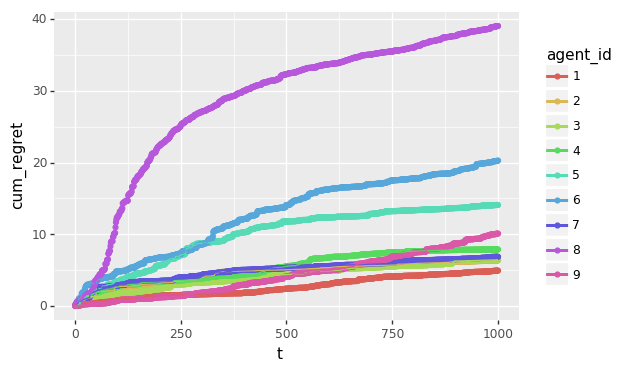

<ggplot: (8764675464349)>


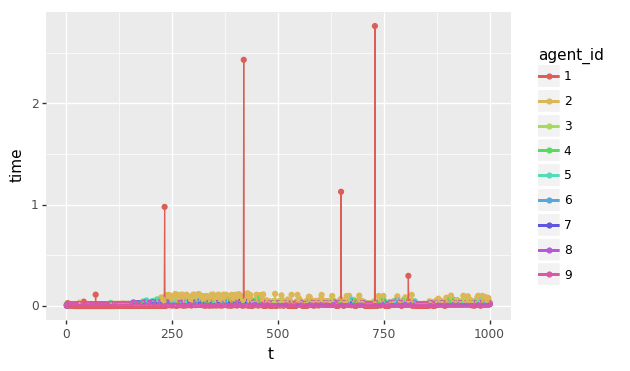

<ggplot: (8764675464233)>


In [14]:
plot_results(results)

In [15]:
pickle.dump((results,cum_regrets), open('../outputs/experiments12_data_d20.p','wb'))

In [16]:
results

[      action_id agent_id  cum_optimal  cum_regret  instant_regret     t  \
 0             1        1     0.999859    0.002092        0.002092     1   
 1             2        2     0.999859    0.000000        0.000000     1   
 2             3        3     0.999859    0.080261        0.080261     1   
 3             4        4     0.999859    0.006690        0.006690     1   
 4             5        5     0.999859    0.072897        0.072897     1   
 5             6        6     0.999859    0.001644        0.001644     1   
 6             7        7     0.999859    0.193926        0.193926     1   
 7             8        8     0.999859    0.016395        0.016395     1   
 8             9        9     0.999859    0.009833        0.009833     1   
 9            10        1     1.999806    0.027837        0.025745     2   
 10           11        2     1.999806    0.019281        0.019281     2   
 11           12        3     1.999806    0.080607        0.000346     2   
 12         

theta [ 0.31678346 -0.4934171   1.21794581  0.43677076 -0.72769267  0.43030744
 -0.68666532 -0.45301801 -0.73285921 -0.75362743 -0.83251892  0.44987187
  1.80752304 -0.48953136  0.88158874 -0.69834087 -0.0499747   1.90752236
 -0.32762267  1.15003185 -0.44868018]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Experiment: Step 33
Experiment: Step 34
Experiment: Step 35
Experiment: Step 36
Experim

Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: Step 426
Experiment: Step 427
Experiment: Step 428
Experiment: Step 429
Experiment: Step 430
Experiment: Step 431
Experiment: S

Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: Step 817
Experiment: Step 818
Experiment: Step 819
Experiment: Step 820
Experiment: Step 821
Experiment: Step 822
Experiment: Step 823
Experiment: Step 824
Experiment: Step 825
Experiment: Step 826
Experiment: Step 827
Experiment: S

Experiment: Step 1165
Experiment: Step 1166
Experiment: Step 1167
Experiment: Step 1168
Experiment: Step 1169
Experiment: Step 1170
Experiment: Step 1171
Experiment: Step 1172
Experiment: Step 1173
Experiment: Step 1174
Experiment: Step 1175
Experiment: Step 1176
Experiment: Step 1177
Experiment: Step 1178
Experiment: Step 1179
Experiment: Step 1180
Experiment: Step 1181
Experiment: Step 1182
Experiment: Step 1183
Experiment: Step 1184
Experiment: Step 1185
Experiment: Step 1186
Experiment: Step 1187
Experiment: Step 1188
Experiment: Step 1189
Experiment: Step 1190
Experiment: Step 1191
Experiment: Step 1192
Experiment: Step 1193
Experiment: Step 1194
Experiment: Step 1195
Experiment: Step 1196
Experiment: Step 1197
Experiment: Step 1198
Experiment: Step 1199
Experiment: Step 1200
Experiment: Step 1201
Experiment: Step 1202
Experiment: Step 1203
Experiment: Step 1204
Experiment: Step 1205
Experiment: Step 1206
Experiment: Step 1207
Experiment: Step 1208
Experiment: Step 1209
Experiment

Experiment: Step 1542
Experiment: Step 1543
Experiment: Step 1544
Experiment: Step 1545
Experiment: Step 1546
Experiment: Step 1547
Experiment: Step 1548
Experiment: Step 1549
Experiment: Step 1550
Experiment: Step 1551
Experiment: Step 1552
Experiment: Step 1553
Experiment: Step 1554
Experiment: Step 1555
Experiment: Step 1556
Experiment: Step 1557
Experiment: Step 1558
Experiment: Step 1559
Experiment: Step 1560
Experiment: Step 1561
Experiment: Step 1562
Experiment: Step 1563
Experiment: Step 1564
Experiment: Step 1565
Experiment: Step 1566
Experiment: Step 1567
Experiment: Step 1568
Experiment: Step 1569
Experiment: Step 1570
Experiment: Step 1571
Experiment: Step 1572
Experiment: Step 1573
Experiment: Step 1574
Experiment: Step 1575
Experiment: Step 1576
Experiment: Step 1577
Experiment: Step 1578
Experiment: Step 1579
Experiment: Step 1580
Experiment: Step 1581
Experiment: Step 1582
Experiment: Step 1583
Experiment: Step 1584
Experiment: Step 1585
Experiment: Step 1586
Experiment

Experiment: Step 1920
Experiment: Step 1921
Experiment: Step 1922
Experiment: Step 1923
Experiment: Step 1924
Experiment: Step 1925
Experiment: Step 1926
Experiment: Step 1927
Experiment: Step 1928
Experiment: Step 1929
Experiment: Step 1930
Experiment: Step 1931
Experiment: Step 1932
Experiment: Step 1933
Experiment: Step 1934
Experiment: Step 1935
Experiment: Step 1936
Experiment: Step 1937
Experiment: Step 1938
Experiment: Step 1939
Experiment: Step 1940
Experiment: Step 1941
Experiment: Step 1942
Experiment: Step 1943
Experiment: Step 1944
Experiment: Step 1945
Experiment: Step 1946
Experiment: Step 1947
Experiment: Step 1948
Experiment: Step 1949
Experiment: Step 1950
Experiment: Step 1951
Experiment: Step 1952
Experiment: Step 1953
Experiment: Step 1954
Experiment: Step 1955
Experiment: Step 1956
Experiment: Step 1957
Experiment: Step 1958
Experiment: Step 1959
Experiment: Step 1960
Experiment: Step 1961
Experiment: Step 1962
Experiment: Step 1963
Experiment: Step 1964
Experiment

Experiment: Step 2298
Experiment: Step 2299
Experiment: Step 2300
Experiment: Step 2301
Experiment: Step 2302
Experiment: Step 2303
Experiment: Step 2304
Experiment: Step 2305
Experiment: Step 2306
Experiment: Step 2307
Experiment: Step 2308
Experiment: Step 2309
Experiment: Step 2310
Experiment: Step 2311
Experiment: Step 2312
Experiment: Step 2313
Experiment: Step 2314
Experiment: Step 2315
Experiment: Step 2316
Experiment: Step 2317
Experiment: Step 2318
Experiment: Step 2319
Experiment: Step 2320
Experiment: Step 2321
Experiment: Step 2322
Experiment: Step 2323
Experiment: Step 2324
Experiment: Step 2325
Experiment: Step 2326
Experiment: Step 2327
Experiment: Step 2328
Experiment: Step 2329
Experiment: Step 2330
Experiment: Step 2331
Experiment: Step 2332
Experiment: Step 2333
Experiment: Step 2334
Experiment: Step 2335
Experiment: Step 2336
Experiment: Step 2337
Experiment: Step 2338
Experiment: Step 2339
Experiment: Step 2340
Experiment: Step 2341
Experiment: Step 2342
Experiment

Experiment: Step 2671
Experiment: Step 2672
Experiment: Step 2673
Experiment: Step 2674
Experiment: Step 2675
Experiment: Step 2676
Experiment: Step 2677
Experiment: Step 2678
Experiment: Step 2679
Experiment: Step 2680
Experiment: Step 2681
Experiment: Step 2682
Experiment: Step 2683
Experiment: Step 2684
Experiment: Step 2685
Experiment: Step 2686
Experiment: Step 2687
Experiment: Step 2688
Experiment: Step 2689
Experiment: Step 2690
Experiment: Step 2691
Experiment: Step 2692
Experiment: Step 2693
Experiment: Step 2694
Experiment: Step 2695
Experiment: Step 2696
Experiment: Step 2697
Experiment: Step 2698
Experiment: Step 2699
Experiment: Step 2700
Experiment: Step 2701
Experiment: Step 2702
Experiment: Step 2703
Experiment: Step 2704
Experiment: Step 2705
Experiment: Step 2706
Experiment: Step 2707
Experiment: Step 2708
Experiment: Step 2709
Experiment: Step 2710
Experiment: Step 2711
Experiment: Step 2712
Experiment: Step 2713
Experiment: Step 2714
Experiment: Step 2715
Experiment

Experiment: Step 3046
Experiment: Step 3047
Experiment: Step 3048
Experiment: Step 3049
Experiment: Step 3050
Experiment: Step 3051
Experiment: Step 3052
Experiment: Step 3053
Experiment: Step 3054
Experiment: Step 3055
Experiment: Step 3056
Experiment: Step 3057
Experiment: Step 3058
Experiment: Step 3059
Experiment: Step 3060
Experiment: Step 3061
Experiment: Step 3062
Experiment: Step 3063
Experiment: Step 3064
Experiment: Step 3065
Experiment: Step 3066
Experiment: Step 3067
Experiment: Step 3068
Experiment: Step 3069
Experiment: Step 3070
Experiment: Step 3071
Experiment: Step 3072
Experiment: Step 3073
Experiment: Step 3074
Experiment: Step 3075
Experiment: Step 3076
Experiment: Step 3077
Experiment: Step 3078
Experiment: Step 3079
Experiment: Step 3080
Experiment: Step 3081
Experiment: Step 3082
Experiment: Step 3083
Experiment: Step 3084
Experiment: Step 3085
Experiment: Step 3086
Experiment: Step 3087
Experiment: Step 3088
Experiment: Step 3089
Experiment: Step 3090
Experiment

Experiment: Step 3422
Experiment: Step 3423
Experiment: Step 3424
Experiment: Step 3425
Experiment: Step 3426
Experiment: Step 3427
Experiment: Step 3428
Experiment: Step 3429
Experiment: Step 3430
Experiment: Step 3431
Experiment: Step 3432
Experiment: Step 3433
Experiment: Step 3434
Experiment: Step 3435
Experiment: Step 3436
Experiment: Step 3437
Experiment: Step 3438
Experiment: Step 3439
Experiment: Step 3440
Experiment: Step 3441
Experiment: Step 3442
Experiment: Step 3443
Experiment: Step 3444
Experiment: Step 3445
Experiment: Step 3446
Experiment: Step 3447
Experiment: Step 3448
Experiment: Step 3449
Experiment: Step 3450
Experiment: Step 3451
Experiment: Step 3452
Experiment: Step 3453
Experiment: Step 3454
Experiment: Step 3455
Experiment: Step 3456
Experiment: Step 3457
Experiment: Step 3458
Experiment: Step 3459
Experiment: Step 3460
Experiment: Step 3461
Experiment: Step 3462
Experiment: Step 3463
Experiment: Step 3464
Experiment: Step 3465
Experiment: Step 3466
Experiment

Experiment: Step 3797
Experiment: Step 3798
Experiment: Step 3799
Experiment: Step 3800
Experiment: Step 3801
Experiment: Step 3802
Experiment: Step 3803
Experiment: Step 3804
Experiment: Step 3805
Experiment: Step 3806
Experiment: Step 3807
Experiment: Step 3808
Experiment: Step 3809
Experiment: Step 3810
Experiment: Step 3811
Experiment: Step 3812
Experiment: Step 3813
Experiment: Step 3814
Experiment: Step 3815
Experiment: Step 3816
Experiment: Step 3817
Experiment: Step 3818
Experiment: Step 3819
Experiment: Step 3820
Experiment: Step 3821
Experiment: Step 3822
Experiment: Step 3823
Experiment: Step 3824
Experiment: Step 3825
Experiment: Step 3826
Experiment: Step 3827
Experiment: Step 3828
Experiment: Step 3829
Experiment: Step 3830
Experiment: Step 3831
Experiment: Step 3832
Experiment: Step 3833
Experiment: Step 3834
Experiment: Step 3835
Experiment: Step 3836
Experiment: Step 3837
Experiment: Step 3838
Experiment: Step 3839
Experiment: Step 3840
Experiment: Step 3841
Experiment

Experiment: Step 4171
Experiment: Step 4172
Experiment: Step 4173
Experiment: Step 4174
Experiment: Step 4175
Experiment: Step 4176
Experiment: Step 4177
Experiment: Step 4178
Experiment: Step 4179
Experiment: Step 4180
Experiment: Step 4181
Experiment: Step 4182
Experiment: Step 4183
Experiment: Step 4184
Experiment: Step 4185
Experiment: Step 4186
Experiment: Step 4187
Experiment: Step 4188
Experiment: Step 4189
Experiment: Step 4190
Experiment: Step 4191
Experiment: Step 4192
Experiment: Step 4193
Experiment: Step 4194
Experiment: Step 4195
Experiment: Step 4196
Experiment: Step 4197
Experiment: Step 4198
Experiment: Step 4199
Experiment: Step 4200
Experiment: Step 4201
Experiment: Step 4202
Experiment: Step 4203
Experiment: Step 4204
Experiment: Step 4205
Experiment: Step 4206
Experiment: Step 4207
Experiment: Step 4208
Experiment: Step 4209
Experiment: Step 4210
Experiment: Step 4211
Experiment: Step 4212
Experiment: Step 4213
Experiment: Step 4214
Experiment: Step 4215
Experiment

Experiment: Step 4549
Experiment: Step 4550
Experiment: Step 4551
Experiment: Step 4552
Experiment: Step 4553
Experiment: Step 4554
Experiment: Step 4555
Experiment: Step 4556
Experiment: Step 4557
Experiment: Step 4558
Experiment: Step 4559
Experiment: Step 4560
Experiment: Step 4561
Experiment: Step 4562
Experiment: Step 4563
Experiment: Step 4564
Experiment: Step 4565
Experiment: Step 4566
Experiment: Step 4567
Experiment: Step 4568
Experiment: Step 4569
Experiment: Step 4570
Experiment: Step 4571
Experiment: Step 4572
Experiment: Step 4573
Experiment: Step 4574
Experiment: Step 4575
Experiment: Step 4576
Experiment: Step 4577
Experiment: Step 4578
Experiment: Step 4579
Experiment: Step 4580
Experiment: Step 4581
Experiment: Step 4582
Experiment: Step 4583
Experiment: Step 4584
Experiment: Step 4585
Experiment: Step 4586
Experiment: Step 4587
Experiment: Step 4588
Experiment: Step 4589
Experiment: Step 4590
Experiment: Step 4591
Experiment: Step 4592
Experiment: Step 4593
Experiment

Experiment: Step 4922
Experiment: Step 4923
Experiment: Step 4924
Experiment: Step 4925
Experiment: Step 4926
Experiment: Step 4927
Experiment: Step 4928
Experiment: Step 4929
Experiment: Step 4930
Experiment: Step 4931
Experiment: Step 4932
Experiment: Step 4933
Experiment: Step 4934
Experiment: Step 4935
Experiment: Step 4936
Experiment: Step 4937
Experiment: Step 4938
Experiment: Step 4939
Experiment: Step 4940
Experiment: Step 4941
Experiment: Step 4942
Experiment: Step 4943
Experiment: Step 4944
Experiment: Step 4945
Experiment: Step 4946
Experiment: Step 4947
Experiment: Step 4948
Experiment: Step 4949
Experiment: Step 4950
Experiment: Step 4951
Experiment: Step 4952
Experiment: Step 4953
Experiment: Step 4954
Experiment: Step 4955
Experiment: Step 4956
Experiment: Step 4957
Experiment: Step 4958
Experiment: Step 4959
Experiment: Step 4960
Experiment: Step 4961
Experiment: Step 4962
Experiment: Step 4963
Experiment: Step 4964
Experiment: Step 4965
Experiment: Step 4966
Experiment

Experiment: Step 5298
Experiment: Step 5299
Experiment: Step 5300
Experiment: Step 5301
Experiment: Step 5302
Experiment: Step 5303
Experiment: Step 5304
Experiment: Step 5305
Experiment: Step 5306
Experiment: Step 5307
Experiment: Step 5308
Experiment: Step 5309
Experiment: Step 5310
Experiment: Step 5311
Experiment: Step 5312
Experiment: Step 5313
Experiment: Step 5314
Experiment: Step 5315
Experiment: Step 5316
Experiment: Step 5317
Experiment: Step 5318
Experiment: Step 5319
Experiment: Step 5320
Experiment: Step 5321
Experiment: Step 5322
Experiment: Step 5323
Experiment: Step 5324
Experiment: Step 5325
Experiment: Step 5326
Experiment: Step 5327
Experiment: Step 5328
Experiment: Step 5329
Experiment: Step 5330
Experiment: Step 5331
Experiment: Step 5332
Experiment: Step 5333
Experiment: Step 5334
Experiment: Step 5335
Experiment: Step 5336
Experiment: Step 5337
Experiment: Step 5338
Experiment: Step 5339
Experiment: Step 5340
Experiment: Step 5341
Experiment: Step 5342
Experiment

Experiment: Step 5674
Experiment: Step 5675
Experiment: Step 5676
Experiment: Step 5677
Experiment: Step 5678
Experiment: Step 5679
Experiment: Step 5680
Experiment: Step 5681
Experiment: Step 5682
Experiment: Step 5683
Experiment: Step 5684
Experiment: Step 5685
Experiment: Step 5686
Experiment: Step 5687
Experiment: Step 5688
Experiment: Step 5689
Experiment: Step 5690
Experiment: Step 5691
Experiment: Step 5692
Experiment: Step 5693
Experiment: Step 5694
Experiment: Step 5695
Experiment: Step 5696
Experiment: Step 5697
Experiment: Step 5698
Experiment: Step 5699
Experiment: Step 5700
Experiment: Step 5701
Experiment: Step 5702
Experiment: Step 5703
Experiment: Step 5704
Experiment: Step 5705
Experiment: Step 5706
Experiment: Step 5707
Experiment: Step 5708
Experiment: Step 5709
Experiment: Step 5710
Experiment: Step 5711
Experiment: Step 5712
Experiment: Step 5713
Experiment: Step 5714
Experiment: Step 5715
Experiment: Step 5716
Experiment: Step 5717
Experiment: Step 5718
Experiment

Experiment: Step 6049
Experiment: Step 6050
Experiment: Step 6051
Experiment: Step 6052
Experiment: Step 6053
Experiment: Step 6054
Experiment: Step 6055
Experiment: Step 6056
Experiment: Step 6057
Experiment: Step 6058
Experiment: Step 6059
Experiment: Step 6060
Experiment: Step 6061
Experiment: Step 6062
Experiment: Step 6063
Experiment: Step 6064
Experiment: Step 6065
Experiment: Step 6066
Experiment: Step 6067
Experiment: Step 6068
Experiment: Step 6069
Experiment: Step 6070
Experiment: Step 6071
Experiment: Step 6072
Experiment: Step 6073
Experiment: Step 6074
Experiment: Step 6075
Experiment: Step 6076
Experiment: Step 6077
Experiment: Step 6078
Experiment: Step 6079
Experiment: Step 6080
Experiment: Step 6081
Experiment: Step 6082
Experiment: Step 6083
Experiment: Step 6084
Experiment: Step 6085
Experiment: Step 6086
Experiment: Step 6087
Experiment: Step 6088
Experiment: Step 6089
Experiment: Step 6090
Experiment: Step 6091
Experiment: Step 6092
Experiment: Step 6093
Experiment

Experiment: Step 6422
Experiment: Step 6423
Experiment: Step 6424
Experiment: Step 6425
Experiment: Step 6426
Experiment: Step 6427
Experiment: Step 6428
Experiment: Step 6429
Experiment: Step 6430
Experiment: Step 6431
Experiment: Step 6432
Experiment: Step 6433
Experiment: Step 6434
Experiment: Step 6435
Experiment: Step 6436
Experiment: Step 6437
Experiment: Step 6438
Experiment: Step 6439
Experiment: Step 6440
Experiment: Step 6441
Experiment: Step 6442
Experiment: Step 6443
Experiment: Step 6444
Experiment: Step 6445
Experiment: Step 6446
Experiment: Step 6447
Experiment: Step 6448
Experiment: Step 6449
Experiment: Step 6450
Experiment: Step 6451
Experiment: Step 6452
Experiment: Step 6453
Experiment: Step 6454
Experiment: Step 6455
Experiment: Step 6456
Experiment: Step 6457
Experiment: Step 6458
Experiment: Step 6459
Experiment: Step 6460
Experiment: Step 6461
Experiment: Step 6462
Experiment: Step 6463
Experiment: Step 6464
Experiment: Step 6465
Experiment: Step 6466
Experiment

Experiment: Step 6798
Experiment: Step 6799
Experiment: Step 6800
Experiment: Step 6801
Experiment: Step 6802
Experiment: Step 6803
Experiment: Step 6804
Experiment: Step 6805
Experiment: Step 6806
Experiment: Step 6807
Experiment: Step 6808
Experiment: Step 6809
Experiment: Step 6810
Experiment: Step 6811
Experiment: Step 6812
Experiment: Step 6813
Experiment: Step 6814
Experiment: Step 6815
Experiment: Step 6816
Experiment: Step 6817
Experiment: Step 6818
Experiment: Step 6819
Experiment: Step 6820
Experiment: Step 6821
Experiment: Step 6822
Experiment: Step 6823
Experiment: Step 6824
Experiment: Step 6825
Experiment: Step 6826
Experiment: Step 6827
Experiment: Step 6828
Experiment: Step 6829
Experiment: Step 6830
Experiment: Step 6831
Experiment: Step 6832
Experiment: Step 6833
Experiment: Step 6834
Experiment: Step 6835
Experiment: Step 6836
Experiment: Step 6837
Experiment: Step 6838
Experiment: Step 6839
Experiment: Step 6840
Experiment: Step 6841
Experiment: Step 6842
Experiment

Experiment: Step 7171
Experiment: Step 7172
Experiment: Step 7173
Experiment: Step 7174
Experiment: Step 7175
Experiment: Step 7176
Experiment: Step 7177
Experiment: Step 7178
Experiment: Step 7179
Experiment: Step 7180
Experiment: Step 7181
Experiment: Step 7182
Experiment: Step 7183
Experiment: Step 7184
Experiment: Step 7185
Experiment: Step 7186
Experiment: Step 7187
Experiment: Step 7188
Experiment: Step 7189
Experiment: Step 7190
Experiment: Step 7191
Experiment: Step 7192
Experiment: Step 7193
Experiment: Step 7194
Experiment: Step 7195
Experiment: Step 7196
Experiment: Step 7197
Experiment: Step 7198
Experiment: Step 7199
Experiment: Step 7200
Experiment: Step 7201
Experiment: Step 7202
Experiment: Step 7203
Experiment: Step 7204
Experiment: Step 7205
Experiment: Step 7206
Experiment: Step 7207
Experiment: Step 7208
Experiment: Step 7209
Experiment: Step 7210
Experiment: Step 7211
Experiment: Step 7212
Experiment: Step 7213
Experiment: Step 7214
Experiment: Step 7215
Experiment

Experiment: Step 7546
Experiment: Step 7547
Experiment: Step 7548
Experiment: Step 7549
Experiment: Step 7550
Experiment: Step 7551
Experiment: Step 7552
Experiment: Step 7553
Experiment: Step 7554
Experiment: Step 7555
Experiment: Step 7556
Experiment: Step 7557
Experiment: Step 7558
Experiment: Step 7559
Experiment: Step 7560
Experiment: Step 7561
Experiment: Step 7562
Experiment: Step 7563
Experiment: Step 7564
Experiment: Step 7565
Experiment: Step 7566
Experiment: Step 7567
Experiment: Step 7568
Experiment: Step 7569
Experiment: Step 7570
Experiment: Step 7571
Experiment: Step 7572
Experiment: Step 7573
Experiment: Step 7574
Experiment: Step 7575
Experiment: Step 7576
Experiment: Step 7577
Experiment: Step 7578
Experiment: Step 7579
Experiment: Step 7580
Experiment: Step 7581
Experiment: Step 7582
Experiment: Step 7583
Experiment: Step 7584
Experiment: Step 7585
Experiment: Step 7586
Experiment: Step 7587
Experiment: Step 7588
Experiment: Step 7589
Experiment: Step 7590
Experiment

Experiment: Step 7922
Experiment: Step 7923
Experiment: Step 7924
Experiment: Step 7925
Experiment: Step 7926
Experiment: Step 7927
Experiment: Step 7928
Experiment: Step 7929
Experiment: Step 7930
Experiment: Step 7931
Experiment: Step 7932
Experiment: Step 7933
Experiment: Step 7934
Experiment: Step 7935
Experiment: Step 7936
Experiment: Step 7937
Experiment: Step 7938
Experiment: Step 7939
Experiment: Step 7940
Experiment: Step 7941
Experiment: Step 7942
Experiment: Step 7943
Experiment: Step 7944
Experiment: Step 7945
Experiment: Step 7946
Experiment: Step 7947
Experiment: Step 7948
Experiment: Step 7949
Experiment: Step 7950
Experiment: Step 7951
Experiment: Step 7952
Experiment: Step 7953
Experiment: Step 7954
Experiment: Step 7955
Experiment: Step 7956
Experiment: Step 7957
Experiment: Step 7958
Experiment: Step 7959
Experiment: Step 7960
Experiment: Step 7961
Experiment: Step 7962
Experiment: Step 7963
Experiment: Step 7964
Experiment: Step 7965
Experiment: Step 7966
Experiment

Experiment: Step 8298
Experiment: Step 8299
Experiment: Step 8300
Experiment: Step 8301
Experiment: Step 8302
Experiment: Step 8303
Experiment: Step 8304
Experiment: Step 8305
Experiment: Step 8306
Experiment: Step 8307
Experiment: Step 8308
Experiment: Step 8309
Experiment: Step 8310
Experiment: Step 8311
Experiment: Step 8312
Experiment: Step 8313
Experiment: Step 8314
Experiment: Step 8315
Experiment: Step 8316
Experiment: Step 8317
Experiment: Step 8318
Experiment: Step 8319
Experiment: Step 8320
Experiment: Step 8321
Experiment: Step 8322
Experiment: Step 8323
Experiment: Step 8324
Experiment: Step 8325
Experiment: Step 8326
Experiment: Step 8327
Experiment: Step 8328
Experiment: Step 8329
Experiment: Step 8330
Experiment: Step 8331
Experiment: Step 8332
Experiment: Step 8333
Experiment: Step 8334
Experiment: Step 8335
Experiment: Step 8336
Experiment: Step 8337
Experiment: Step 8338
Experiment: Step 8339
Experiment: Step 8340
Experiment: Step 8341
Experiment: Step 8342
Experiment

Experiment: Step 8673
Experiment: Step 8674
Experiment: Step 8675
Experiment: Step 8676
Experiment: Step 8677
Experiment: Step 8678
Experiment: Step 8679
Experiment: Step 8680
Experiment: Step 8681
Experiment: Step 8682
Experiment: Step 8683
Experiment: Step 8684
Experiment: Step 8685
Experiment: Step 8686
Experiment: Step 8687
Experiment: Step 8688
Experiment: Step 8689
Experiment: Step 8690
Experiment: Step 8691
Experiment: Step 8692
Experiment: Step 8693
Experiment: Step 8694
Experiment: Step 8695
Experiment: Step 8696
Experiment: Step 8697
Experiment: Step 8698
Experiment: Step 8699
Experiment: Step 8700
Experiment: Step 8701
Experiment: Step 8702
Experiment: Step 8703
Experiment: Step 8704
Experiment: Step 8705
Experiment: Step 8706
Experiment: Step 8707
Experiment: Step 8708
Experiment: Step 8709
Experiment: Step 8710
Experiment: Step 8711
Experiment: Step 8712
Experiment: Step 8713
Experiment: Step 8714
Experiment: Step 8715
Experiment: Step 8716
Experiment: Step 8717
Experiment

Experiment: Step 9049
Experiment: Step 9050
Experiment: Step 9051
Experiment: Step 9052
Experiment: Step 9053
Experiment: Step 9054
Experiment: Step 9055
Experiment: Step 9056
Experiment: Step 9057
Experiment: Step 9058
Experiment: Step 9059
Experiment: Step 9060
Experiment: Step 9061
Experiment: Step 9062
Experiment: Step 9063
Experiment: Step 9064
Experiment: Step 9065
Experiment: Step 9066
Experiment: Step 9067
Experiment: Step 9068
Experiment: Step 9069
Experiment: Step 9070
Experiment: Step 9071
Experiment: Step 9072
Experiment: Step 9073
Experiment: Step 9074
Experiment: Step 9075
Experiment: Step 9076
Experiment: Step 9077
Experiment: Step 9078
Experiment: Step 9079
Experiment: Step 9080
Experiment: Step 9081
Experiment: Step 9082
Experiment: Step 9083
Experiment: Step 9084
Experiment: Step 9085
Experiment: Step 9086
Experiment: Step 9087
Experiment: Step 9088
Experiment: Step 9089
Experiment: Step 9090
Experiment: Step 9091
Experiment: Step 9092
Experiment: Step 9093
Experiment

Experiment: Step 9423
Experiment: Step 9424
Experiment: Step 9425
Experiment: Step 9426
Experiment: Step 9427
Experiment: Step 9428
Experiment: Step 9429
Experiment: Step 9430
Experiment: Step 9431
Experiment: Step 9432
Experiment: Step 9433
Experiment: Step 9434
Experiment: Step 9435
Experiment: Step 9436
Experiment: Step 9437
Experiment: Step 9438
Experiment: Step 9439
Experiment: Step 9440
Experiment: Step 9441
Experiment: Step 9442
Experiment: Step 9443
Experiment: Step 9444
Experiment: Step 9445
Experiment: Step 9446
Experiment: Step 9447
Experiment: Step 9448
Experiment: Step 9449
Experiment: Step 9450
Experiment: Step 9451
Experiment: Step 9452
Experiment: Step 9453
Experiment: Step 9454
Experiment: Step 9455
Experiment: Step 9456
Experiment: Step 9457
Experiment: Step 9458
Experiment: Step 9459
Experiment: Step 9460
Experiment: Step 9461
Experiment: Step 9462
Experiment: Step 9463
Experiment: Step 9464
Experiment: Step 9465
Experiment: Step 9466
Experiment: Step 9467
Experiment

Experiment: Step 9798
Experiment: Step 9799
Experiment: Step 9800
Experiment: Step 9801
Experiment: Step 9802
Experiment: Step 9803
Experiment: Step 9804
Experiment: Step 9805
Experiment: Step 9806
Experiment: Step 9807
Experiment: Step 9808
Experiment: Step 9809
Experiment: Step 9810
Experiment: Step 9811
Experiment: Step 9812
Experiment: Step 9813
Experiment: Step 9814
Experiment: Step 9815
Experiment: Step 9816
Experiment: Step 9817
Experiment: Step 9818
Experiment: Step 9819
Experiment: Step 9820
Experiment: Step 9821
Experiment: Step 9822
Experiment: Step 9823
Experiment: Step 9824
Experiment: Step 9825
Experiment: Step 9826
Experiment: Step 9827
Experiment: Step 9828
Experiment: Step 9829
Experiment: Step 9830
Experiment: Step 9831
Experiment: Step 9832
Experiment: Step 9833
Experiment: Step 9834
Experiment: Step 9835
Experiment: Step 9836
Experiment: Step 9837
Experiment: Step 9838
Experiment: Step 9839
Experiment: Step 9840
Experiment: Step 9841
Experiment: Step 9842
Experiment

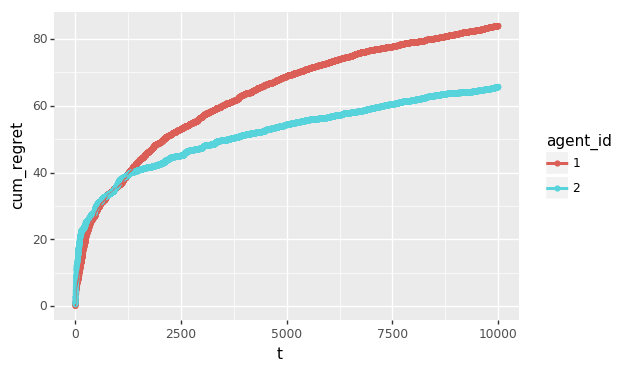

<ggplot: (8764867084069)>


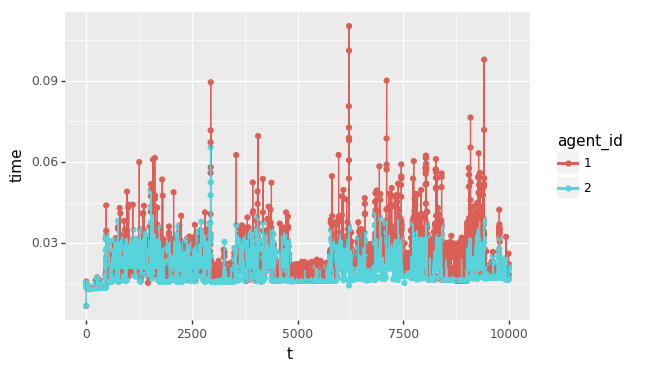

<ggplot: (8764867310281)>


In [18]:
agents = [make_pgts_agent(),
          make_sagald_agent()]
results10000, cum_regrets10000 = simple_compare(agents, num_articles, dim, sparsity, 10000, seed=201, verbosity=1)
plot_results(results10000)
pickle.dump((results10000,cum_regrets10000), open('../outputs/experiments12_data_d20_10000.p','wb'))

In [19]:
#from algorithms.langevin import *
npla.eig(logistic_Hessian(agents[1].theta, agents[1].contexts))

(array([2201.43955084,   13.17097062,   43.06269559,   56.58453875,
          61.12849116,   63.94947511,   68.25244473,   73.02312289,
         145.97590523,  143.75702936,  136.74799597,  134.08521428,
         128.28447254,  123.11929034,   88.08144261,  115.01577724,
          92.98485613,  108.93718385,  104.59094941,  102.68551697,
          98.97645634]),
 array([[ 4.91321680e-01,  8.55365739e-01, -2.00090918e-02,
         -9.28672937e-02,  8.27577616e-02,  3.95826309e-02,
          3.14505401e-02, -1.90656157e-02, -1.27997180e-02,
         -1.29065658e-02,  1.37086568e-02, -1.00986776e-03,
          1.12539336e-02, -2.26710236e-02, -4.63184646e-02,
          2.20439723e-03, -3.62178987e-03,  3.25581475e-03,
         -6.72153819e-02,  1.71680917e-02, -3.58901025e-03],
        [ 1.12252594e-01, -4.22408647e-02, -4.48756892e-03,
          3.61230208e-02, -8.87421842e-02, -3.41631540e-02,
         -2.34919066e-02, -7.52747382e-02,  1.04412674e-02,
          5.16865384e-02,  4.42656

theta [ 0.98688681 -1.7160776   0.35133485  2.00711271 -0.3932066   1.75328969
  0.83412094  0.97258008  1.45799666 -0.86404959 -1.12557741  0.66118012
 -2.29663349  0.80666609  0.89322918  0.58363088  1.07410719  0.72007726
  0.68752484 -0.55261018 -0.25262928]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
Experiment: Step 33
Experiment: Step 34
Experiment: Step 35
Experiment: Step 36
Experim

Experiment: Step 383
Experiment: Step 384
Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: Step 426
Experiment: Step 427
Experiment: Step 428
Experiment: Step 429
Experiment: S

Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: Step 817
Experiment: Step 818
Experiment: Step 819
Experiment: Step 820
Experiment: Step 821
Experiment: S

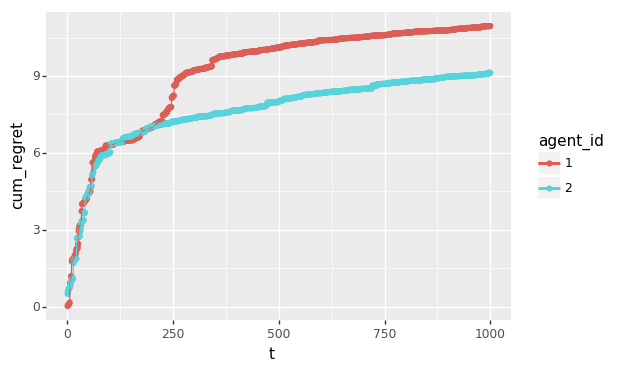

<ggplot: (8764672241377)>


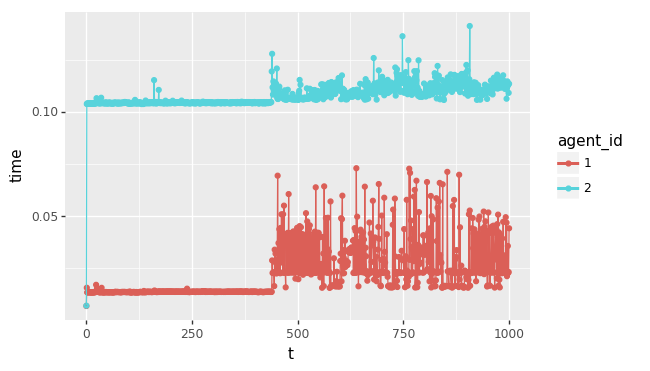

<ggplot: (8764673328853)>


In [25]:
make_prec_full_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=0.1,
                                          n_steps=9999,
                                          precondition='full',
                                          init_pt=None, verbosity=verbosity)

agents3 = [make_sagald_agent(), make_prec_full_sagald_agent()]

results3, cum_regrets3= simple_compare(agents3, num_articles, dim, sparsity, 1000, seed=301, verbosity=1)
plot_results(results3)
pickle.dump((results3,cum_regrets3), open('../outputs/experiments12_data_d20_3.p','wb'))

theta [-8.76395317e-01  1.24286860e+00 -8.99547301e-01  7.80467995e-02
 -9.11241747e-01  7.50631118e-01  1.67308509e+00 -3.74943108e-01
  6.05221636e-02 -8.42137543e-01 -1.63041928e-01  1.93689366e+00
  1.19210556e+00  1.48302313e+00 -1.32815212e+00  4.38939339e-01
 -1.25005356e-04 -3.59249270e-01  1.13588288e+00 -1.09598914e+00
 -8.18086609e-01]
Experiment: Step 0
Experiment: Step 1
Experiment: Step 2
Experiment: Step 3
Experiment: Step 4
Experiment: Step 5
Experiment: Step 6
Experiment: Step 7
Experiment: Step 8
Experiment: Step 9
Experiment: Step 10
Experiment: Step 11
Experiment: Step 12
Experiment: Step 13
Experiment: Step 14
Experiment: Step 15
Experiment: Step 16
Experiment: Step 17
Experiment: Step 18
Experiment: Step 19
Experiment: Step 20
Experiment: Step 21
Experiment: Step 22
Experiment: Step 23
Experiment: Step 24
Experiment: Step 25
Experiment: Step 26
Experiment: Step 27
Experiment: Step 28
Experiment: Step 29
Experiment: Step 30
Experiment: Step 31
Experiment: Step 32
E

Experiment: Step 379
Experiment: Step 380
Experiment: Step 381
Experiment: Step 382
Experiment: Step 383
Experiment: Step 384
Experiment: Step 385
Experiment: Step 386
Experiment: Step 387
Experiment: Step 388
Experiment: Step 389
Experiment: Step 390
Experiment: Step 391
Experiment: Step 392
Experiment: Step 393
Experiment: Step 394
Experiment: Step 395
Experiment: Step 396
Experiment: Step 397
Experiment: Step 398
Experiment: Step 399
Experiment: Step 400
Experiment: Step 401
Experiment: Step 402
Experiment: Step 403
Experiment: Step 404
Experiment: Step 405
Experiment: Step 406
Experiment: Step 407
Experiment: Step 408
Experiment: Step 409
Experiment: Step 410
Experiment: Step 411
Experiment: Step 412
Experiment: Step 413
Experiment: Step 414
Experiment: Step 415
Experiment: Step 416
Experiment: Step 417
Experiment: Step 418
Experiment: Step 419
Experiment: Step 420
Experiment: Step 421
Experiment: Step 422
Experiment: Step 423
Experiment: Step 424
Experiment: Step 425
Experiment: S

Experiment: Step 770
Experiment: Step 771
Experiment: Step 772
Experiment: Step 773
Experiment: Step 774
Experiment: Step 775
Experiment: Step 776
Experiment: Step 777
Experiment: Step 778
Experiment: Step 779
Experiment: Step 780
Experiment: Step 781
Experiment: Step 782
Experiment: Step 783
Experiment: Step 784
Experiment: Step 785
Experiment: Step 786
Experiment: Step 787
Experiment: Step 788
Experiment: Step 789
Experiment: Step 790
Experiment: Step 791
Experiment: Step 792
Experiment: Step 793
Experiment: Step 794
Experiment: Step 795
Experiment: Step 796
Experiment: Step 797
Experiment: Step 798
Experiment: Step 799
Experiment: Step 800
Experiment: Step 801
Experiment: Step 802
Experiment: Step 803
Experiment: Step 804
Experiment: Step 805
Experiment: Step 806
Experiment: Step 807
Experiment: Step 808
Experiment: Step 809
Experiment: Step 810
Experiment: Step 811
Experiment: Step 812
Experiment: Step 813
Experiment: Step 814
Experiment: Step 815
Experiment: Step 816
Experiment: S

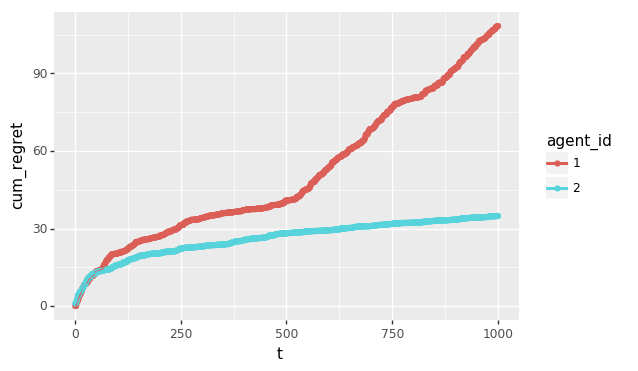

<ggplot: (8764670209821)>


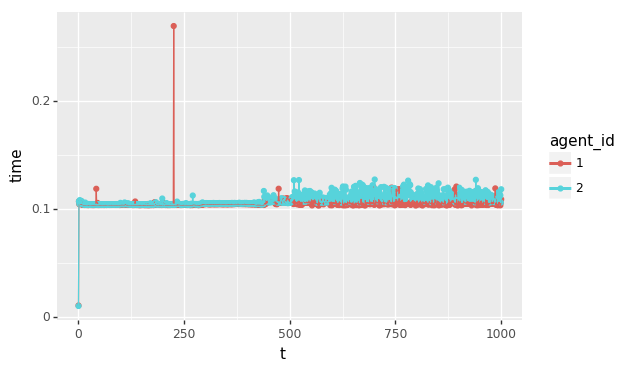

<ggplot: (8764672401649)>


In [26]:
make_prec_full_sagald_agent = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=0.1,
                                          n_steps=9999,
                                          precondition='full',
                                          init_pt=None, verbosity=verbosity)
make_sagald_agent_0_1 = lambda: SAGATS(num_articles, dim1, [0]*(dim1), cov=None, 
                                          step_size=lambda t: 0.05,
                                          batch_size = 64,
                                          time=0.1,
                                          n_steps=9999,
                                          init_pt=None, verbosity=verbosity)

agents4 = [make_sagald_agent_0_1(), make_prec_full_sagald_agent()]

results4, cum_regrets4= simple_compare(agents4, num_articles, dim, sparsity, 1000, seed=401, verbosity=1)
plot_results(results4)
#pickle.dump((results3,cum_regrets3), open('../outputs/experiments12_data_d20_3.p','wb'))

In [6]:
type(np.asarray([1]))

numpy.ndarray

In [7]:
np.asarray([[1]]).shape

(1, 1)